In [1]:
import gzip, pickle, glob
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas
import os
import math

In [2]:
from ConvolutionalNeuralNetwork import ConvolutionalNeuralNetwork
from Standardization import Standardization
from CifarDataset import CifarDataset
from CollateFunction import collate_fn
import DataProcessing as DP
import CNNModelAnalysis as CMA

In [ ]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

In [12]:
!tar -xvf cifar-10-python.tar.gz

x cifar-10-batches-py/
x cifar-10-batches-py/data_batch_4
x cifar-10-batches-py/readme.html
x cifar-10-batches-py/test_batch
x cifar-10-batches-py/data_batch_3
x cifar-10-batches-py/batches.meta
x cifar-10-batches-py/data_batch_2
x cifar-10-batches-py/data_batch_5
x cifar-10-batches-py/data_batch_1


In [3]:
_CURRENTDIR = os.path.abspath('')

In [4]:
data_fpath = _CURRENTDIR + '/cifar-10-batches-py'

# Load the dataset
data_list = []
for file in glob.glob(f'{data_fpath}/data_batch*'):
    with open(file, 'rb') as fo:
        data_list.append(pickle.load(fo, encoding='bytes'))

with open(f'{data_fpath}/batches.meta', 'rb') as f:
    class_names = pickle.load(f, encoding='bytes')
class_names = class_names[b'label_names']

img_list = []
lbl_list = []
for i in range(len(data_list)-1):
    img_list.append(data_list[i][b'data'])
    lbl_list.append(data_list[i][b'labels'])
images = np.vstack(img_list) #data_list[0][b'data']
labels = np.hstack(lbl_list) #data_list[0][b'labels']

In [5]:
images.shape, np.array(labels).shape

((40000, 3072), (40000,))

In [6]:
use_gpu = True

img_channel = 3
wh = int(np.sqrt(images.shape[1] / img_channel))

Xdata = images.reshape(-1, img_channel, wh, wh).astype(np.float32)
Tdata = np.array(labels)

train_data, valid_data = DP.split_data(Xdata, Tdata)

Xtrain, Ttrain = train_data
Xvalid, Tvalid = valid_data
Xtest = data_list[-1][b'data'].reshape(-1, img_channel, wh, wh).astype(np.float32)
Ttest = np.array(data_list[-1][b'labels'])

st_obj = Standardization(Xtrain)

split_tuples_list = [(Xtrain, Ttrain), (Xvalid, Tvalid), (Xtest, Ttest)]

dataset_list = [CifarDataset(stup, st_obj) for stup in split_tuples_list]

batch_size_list = [512, 512, 512] if use_gpu else [32, 32, 32] #[100, 100, 100]
shuffle_list = [True, False, False]

trainloader, validloader, testloader = (torch.utils.data.DataLoader(dataset, 
                                                                    batch_size = batch_size, 
                                                                    collate_fn = collate_fn, 
                                                                    shuffle = shuffle) 
                                        for dataset, batch_size, shuffle 
                                        in zip(dataset_list, batch_size_list, shuffle_list))

In [7]:
# Number of samples in train, validation, and test set
Xtrain.shape, Xvalid.shape, Xtest.shape

((32000, 3, 32, 32), (8000, 3, 32, 32), (10000, 3, 32, 32))

In [14]:
preds_list = []
confs_list = []
evaluation_res_list = []

train_error_list = []
train_error_trace_list = []

valid_error_list = []
valid_error_trace_list = []

width = Xtrain.shape[2]
height = Xtrain.shape[3]
in_channels = Xtrain.shape[1] 
classes = np.unique(Ttrain)
class_names = np.array(class_names).astype(str)
use_gpu = True

# (n_units_in_conv_layers[...], 
# kernel_size_and_stride_padding[[],[],...], 
# maxpool_kernel_stride_padding[[],[],...], 
# n_units_in_fc_layers[...])

# throws error if padding is equal to or greater than kernel size.

arch_list = [([32, 32, 32, 32], [[3, 1, 0], [3, 1, 0], [3, 1, 0], [3, 1, 0]], [None, [2, 1, 0], None, [2, 1, 0]], [128]), 
             ([32, 64, 32, 16], [[3, 1, 0], [3, 1, 0], [3, 1, 0], [3, 1, 0]], [None, [2, 1, 0], None, [2, 1, 0]], [128]), 
             ([16, 32, 64, 32], [[3, 1, 0], [3, 1, 0], [3, 1, 0], [3, 1, 0]], [None, [2, 1, 0], None, [2, 1, 0]], [128]), 
             ([8, 16, 32, 64], [[3, 1, 0], [3, 1, 0], [3, 1, 0], [3, 1, 0]], [None, [2, 1, 0], None, [2, 1, 0]], [128])]

#[([32, 32], [[3, 1, 'same'], [3, 1, 'same']], [[2, 1, 0], [2, 1, 0]], [128])]

lr_list = [0.001, 0.002, 0.0001, 0.01] # [0.001]
n_epochs_list = [10, 10, 10, 10] # [80]

best_vloss = None
states_path = './saved_states/cifar10_model_states.pth'

for arch, learning_rate, n_epochs in zip(arch_list, lr_list, n_epochs_list):

    print('|', end=' ')
    
    n_units_in_conv_layers, kernel_size_and_stride_padding, maxpool_kernel_stride_padding, n_units_in_fc_layers = arch

    conv_model = ConvolutionalNeuralNetwork(in_channels, 
                                            width, 
                                            height, 
                                            n_units_in_conv_layers, 
                                            kernel_size_and_stride_padding, 
                                            maxpool_kernel_stride_padding, 
                                            n_units_in_fc_layers, 
                                            classes, 
                                            use_gpu)
    
    conv_model.train(trainloader, validloader, learning_rate, n_epochs, best_vloss, states_path = states_path)
    best_vloss = conv_model.get_best_validation_loss()
    
    train_error_trace, valid_error_trace = conv_model.get_error_trace()
    train_error = train_error_trace[-1]
    valid_error = valid_error_trace[-1]
    train_error_trace_list.append(train_error_trace)
    train_error_list.append(train_error)
    valid_error_trace_list.append(valid_error_trace)
    valid_error_list.append(valid_error)
    
    Y_preds, Y_confs = conv_model.predict(testloader) #trainloader
    confs_list.append(Y_confs)
    preds_list.append(Y_preds)
    evaluation_res_list.append(conv_model.evaluate(testloader))

| | | | 

In [15]:
pandas.DataFrame([arch_list, n_epochs_list, lr_list, train_error_list, valid_error_list, evaluation_res_list], 
                 index = ['Model Arch', 'Epochs', 'lr', 'Tr-loss', 'Val-loss', 'Test-Acc']).T

,Model Arch,Epochs,lr,Tr-loss,Val-loss,Test-Acc
0,"([32, 32, 32, 32], [[3, 1, 0], [3, 1, 0], [3, ...",10,0.001,0.567033,0.986741,0.6848
1,"([32, 64, 32, 16], [[3, 1, 0], [3, 1, 0], [3, ...",10,0.002,0.68571,1.034736,0.6612
2,"([16, 32, 64, 32], [[3, 1, 0], [3, 1, 0], [3, ...",10,0.0001,1.26573,1.3319,0.5491
3,"([8, 16, 32, 64], [[3, 1, 0], [3, 1, 0], [3, 1...",10,0.01,2.118101,2.141085,0.2172


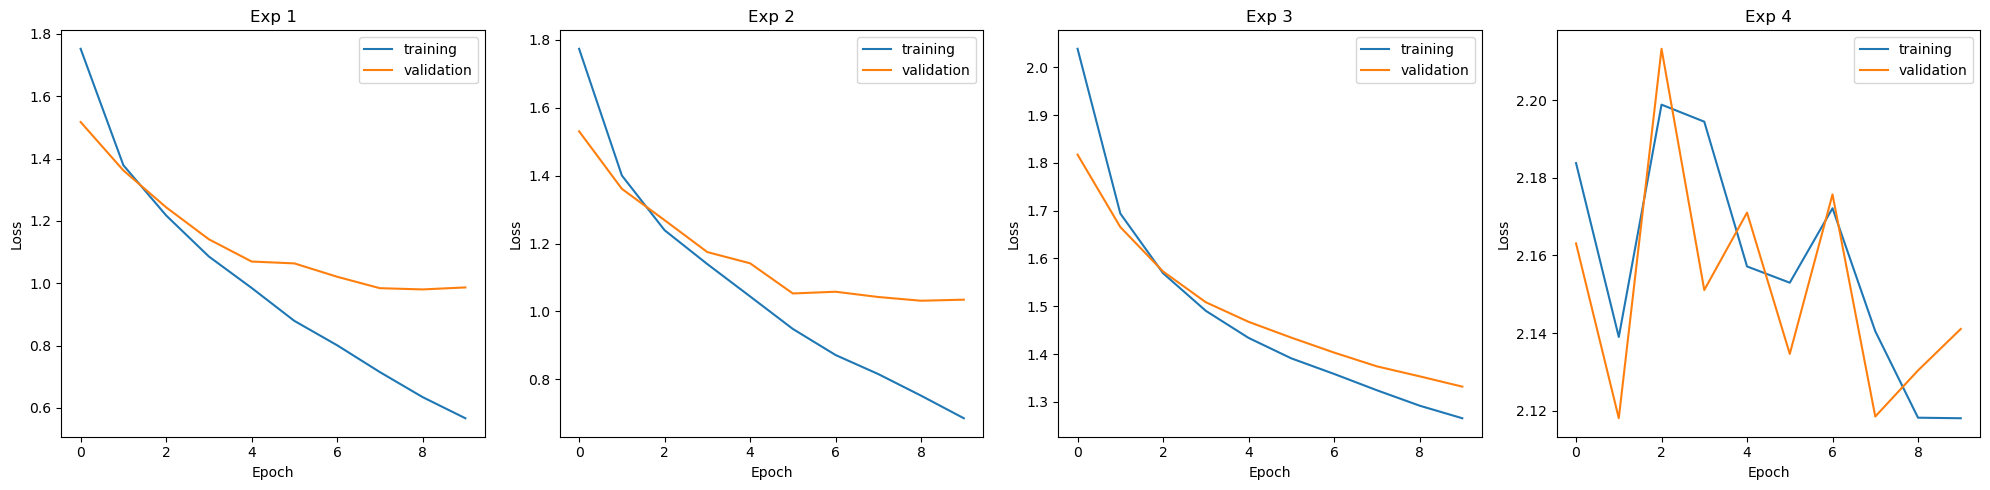

In [16]:
# The loss plots of the experiments.

plt.figure(figsize = (20, 5))
n = len(arch_list)
col = 4 #int(n/4)
row = math.ceil(n/col)
for i in range(n):
    plt.subplot(row, col, i+1)
    plt.plot(train_error_trace_list[i], label = 'training')
    plt.plot(valid_error_trace_list[i], label = 'validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Exp {i+1}')
plt.tight_layout()

In [10]:
# Choose the network with better result, change anything needed, and train longer.

states_path = './saved_states/cifar10_model_states.pth'

checkpoint = torch.load(states_path)
#best_idx = np.argmax(evaluation_res_list)
best_args = checkpoint['model_args']
n_epochs = checkpoint['epoch']
learning_rate = checkpoint['loss']

# Change to this for final script
in_channels, width, height, n_units_in_conv_layers, kernel_size_and_stride_padding, maxpool_kernel_stride_padding, n_units_in_fc_layers, classes, use_gpu, dropout, bnorm = best_args

#n_units_in_conv_layers =  [32, 64, 128] # [32, 32, 32, 32]
#kernel_size_and_stride_padding = [[3, 3, 0], [2, 2, 0], [2, 1, 0]] # [[3, 1, 0], [3, 1, 0]] # , [3, 1, 0], [3, 1, 0]]
#maxpool_kernel_stride_padding =  [[2, 1, 0], [2, 1, 0], [2, 1, 0]] #[None, [2, 1, 0]] #, None, [2, 1, 0]] 
#n_units_in_fc_layers = [] #[128]

learning_rate = 0.001
n_epochs = 20
#dropout = 0.4
#bnorm = False

# Specify a new path for saving the states of this trial.
best_vloss = None
states_path = './saved_states/cifar10_model_states_trial.pth'


conv_model = ConvolutionalNeuralNetwork(in_channels, 
                                        width, 
                                        height, 
                                        n_units_in_conv_layers, 
                                        kernel_size_and_stride_padding, 
                                        maxpool_kernel_stride_padding, 
                                        n_units_in_fc_layers, 
                                        classes, 
                                        use_gpu)

# Now either load the trained model's states and retrain (uncomment the following line)
#conv_model.nnet.load_state_dict(checkpoint['model_state_dict'])

# Or directly train from scratch
conv_model.train(trainloader, validloader, learning_rate, n_epochs, best_vloss = best_vloss, states_path = states_path)
best_vloss = conv_model.get_best_validation_loss()
print(f'Best validation loss: {best_vloss:.3f}')

train_error_trace, valid_error_trace = conv_model.get_error_trace()

Y_preds, Y_confs = conv_model.predict(testloader)
Test_acc = conv_model.evaluate(testloader)
print(f'Test Accuracy: {Test_acc:.3f}')

Best validation loss: 0.972
Test Accuracy: 0.687


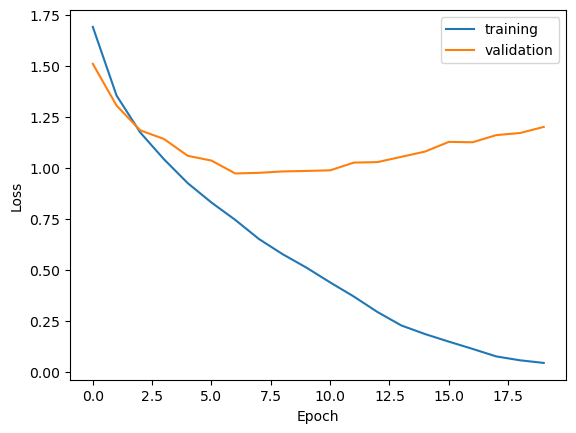

In [11]:
# Loss vs Epoch plot of the above trained model.

plt.plot(train_error_trace, label = 'training')
plt.plot(valid_error_trace, label = 'validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

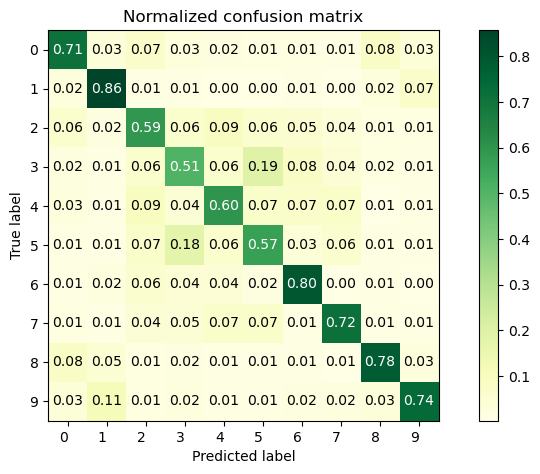

In [12]:
# Add confusion matrix on test set

Pte, Prte = conv_model.predict(testloader) #nnet.use(Xtenn)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
CMA.plot_confusion_matrix(Ttest, Pte, classes=np.unique(Ttest).astype(int),
                      title='Normalized confusion matrix')

plt.show()

In [13]:
# Use the preferred trained model to test on a different set of samples (rerun the dataloader cell to get a different set).
# Use either './saved_states/cifar10_model_states.pth' or './saved_states/cifar10_model_states_trial.pth'

reuse_states_path = './saved_states/cifar10_model_states_trial.pth'
checkpoint = torch.load(reuse_states_path) 

conv_model_resume = ConvolutionalNeuralNetwork(*checkpoint['model_args'])

conv_model_resume.nnet.load_state_dict(checkpoint['model_state_dict'])
Y_pred, Y_conf = conv_model_resume.predict(testloader) 
eval_result = conv_model_resume.evaluate(testloader)
print(f'{eval_result:.4f}')

0.6716


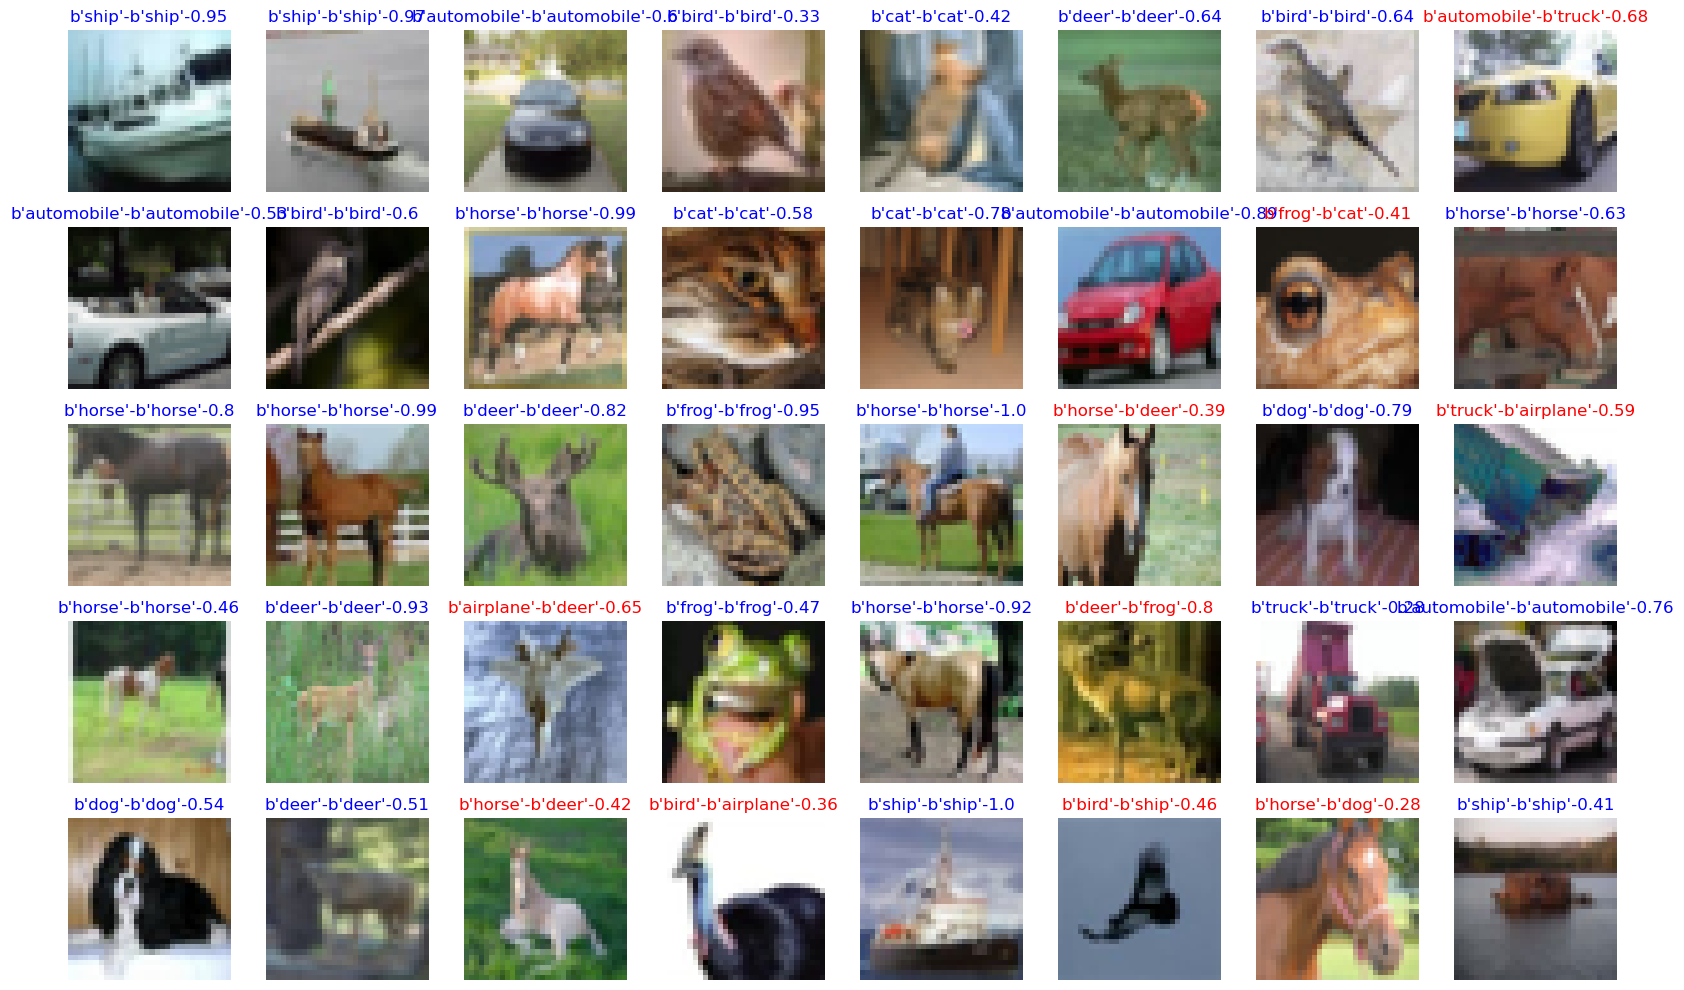

In [19]:
# Inspect visually the images and their prediction (on top of each image) by the model.
# Red titled ones are wrongly predicted.
# Add direct numpy image input along with testloader for predict method.

plt.figure(figsize = (16, 10))
row = 5
col = 8
total = int(row * col)
rand_ind = np.random.randint(0, len(Xtest), total)
for i in range(total):
    plt.subplot(row, col, i+1)
    img = Xtest[rand_ind[i]].transpose(1, 2, 0)
    true_label = class_names[Ttest[rand_ind[i]]]
    pred_label, pred_conf = Y_pred[rand_ind[i]], Y_conf[rand_ind[i]] #conv_model_resume.predict(Xtest_std)
    plt.imshow(img.astype(int))
    plt.title(f'{true_label}-{class_names[pred_label]}-{pred_conf:.2}', color='b' if true_label == class_names[pred_label] else 'r')
    plt.axis('off');
plt.tight_layout()

## Acknowledgements


1.https://stats.stackexchange.com/questions/278524/cant-get-accuracy-above-15-on-cifar-10-dataset

2.https://www.analyticsvidhya.com/blog/2021/09/convolutional-neural-network-pytorch-implementation-on-cifar10-dataset/

3.https://stackoverflow.com/questions/44193270/how-to-calculate-the-output-size-after-convolving-and-pooling-to-the-input-image

4.https://stackoverflow.com/questions/54423078/how-are-the-output-size-of-maxpooling2d-conv2d-upsampling2d-layers-calculated

5.https://github.com/pytorch/pytorch/issues/89336